# Adding custom behavioral events to hyperscanning-EEG data

@Authors:<br>
    Franck Porteous <franck.porteous@proton.me> <br>
    Sean McWeeny <mcweenysean@gmail.com> <br>

This notebook shows how to handle a custom behavioral code dataframe and hyperscanning-EEG data with [MNE-Python](https://mne.tools/stable/index.html). It also demonstrates the subsequent analysis of these data using [HyPyP](https://github.com/ppsp-team/HyPyP).


**Table of content**
>>>>>> ***TO UPDATE AGAIN***
* Import `raw` dual-EEG data (.bdf).
* Change channel names to HyPyP convention.
* Preprocess the EEG data.
* Read custom event df and format it to match the MNE `events` df convention.
* Select ecodes of interest and make MNE `metadata` object from this newly made `events` dataframe.
* epoch the `raw` with `metadata` object.


*To be added*:
* Compute inter-brain connectivity
 * Compute the complex signal with HyPyP
 * Compute Ccorr over the complex signal 
* Execute ICA and auto-reject outside of this notebook (to enable subject-lvl preprocessing) 
* Compare dropped epoch in each subject after preprocessing

## Import

In [1]:
# EEG data manipulation
import mne

# Hyperscanning analysis
import hypyp

# Useful data science tools
import pandas as pd
import numpy as np
import re # regular expressions

# Plotting
import matplotlib.pyplot as plt

# Platform handling
from sys import platform

## Load `raw` data 

Set the study path and "save" folder path

In [2]:
if platform == "darwin":  # OS X
    root     = "../../W2W-Data/W2W-EEG/Franck_eeg_share/"
    saves    = "../../W2W-Data/W2W-EEG/Franck_eeg_share/W2W-saves/"
    saves_ar = "../../W2W-Data/W2W-EEG/Franck_eeg_share/W2W-saves-ar/"
    chan_loc = "./channel_info/locs_files/"

elif platform == "win32": # Windows
    root = "C:\\Users\\mcwee\\Documents\\HyPyP\\social_eeg_project\\data\\"
    saves = "C:\\Users\\mcwee\\Documents\\HyPyP\\social_eeg_project\\data\\saves\\"
    chan_loc = "C:\\Users\\mcwee\\Documents\\HyPyP\\social_eeg_project\\locs\\"

else:
    print("Please insert manually your 'study root' path and 'saves' path")

Set variables regarding the subject of interrest **and** the condition of interest.

In [3]:
subject = 'W2W_2606'
context = 'movie'

# The line below can be substitued for  loop running through participants
bdf_file = subject + "_" + context + ".bdf"
txt_file = subject + "_" + context + "_main.txt"

ecode_file = root + txt_file
eeg_file   = root + bdf_file

#### Load BDF files

Here, we first set up the link(s) to our raw data file(s) and then use [mne.io.read_raw_bdf()](https://mne.tools/stable/generated/mne.io.read_raw_bdf.html?highlight=read%20bdf#mne-io-read-raw-bdf) to read it into an MNE object.

In [4]:
chan_to_exclude = [
    # Adults channels
    '1-EXG1','1-EXG2', # EOG chans
    '1-EXG3','1-EXG4', # Mastoid chans TODO: check whether to include or not
    '1-EXG5','1-EXG6','1-EXG7','1-EXG8',
    '1-GSR1','1-GSR2',
    '1-Erg1','1-Erg2',
    '1-Resp', '1-Plet', '1-Temp',
    # Kids channels
    '2-EXG1','2-EXG2','2-EXG3','2-EXG4','2-EXG5','2-EXG6','2-EXG7','2-EXG8',
    '2-GSR1','2-GSR2',
    '2-Erg1','2-Erg2',
    '2-Resp', '2-Plet', '2-Temp',
    'Status' # added by BioSemi
    ]

raw = mne.io.read_raw_bdf(
    input_fname=eeg_file, 
    # eog=  ['1-EXG1','1-EXG2'],
    exclude= chan_to_exclude,
    preload=True,
    ) 

raw.info

Extracting EDF parameters from C:\Users\mcwee\Documents\HyPyP\social_eeg_project\data\W2W_2606_movie.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 157695  =      0.000 ...   307.998 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: 1-Fp1, 1-AF3, 1-F7, 1-F3, 1-FC1, 1-FC5, 1-T7, 1-C3, 1-CP1, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2018-12-03 12:00:32 UTC
 nchan: 64
 projs: []
 sfreq: 512.0 Hz
>

### Change channel names to HyPyP convention
Hypyp expects the dyadic data to be stored in a merged object (i.e., containing all n channels for each participant) and comply with HyPyP's channel naming convention to distinguish between the two participants' channels.

HyPyPs' channel naming convention consists of a ***suffix*** in the channel name to differentiate each subject (e.g., `_S1` or `_S2`).

Our data currently has a ***prefix*** for each participant's channel (e.g., 1- for subject 1 and 2- for subject two; see below). 

To respect the HyPyP's convention, we will 
* remove the prefix in both participants
* add to both participants their corresponding suffix
* create a replacement dictionary to feed to the [mne.Raw.rename_channels()](https://mne.tools/stable/generated/mne.io.Raw.html?highlight=raw#mne.io.Raw.rename_channels) method and execute the name change

> ❗️ Do not try changing the channel's names yourself by just replacing their name directly in the `Raw` (see [this discourse thread](https://mne.discourse.group/t/set-montage-info-channel-name-inconsistency-error/3881) to learn why).

In [6]:
# Store the ch names of each participant in their lists 
s1_chans_old = [i for i in raw.ch_names if re.search(r'1-', i) ]
s2_chans_old = [i for i in raw.ch_names if re.search(r'2-', i) ]

# Just checking that the adult has 2 additional channel compared to the kid ('EXG1_S1', 'EXG2_S1')
# assert len(s1_chans_old) == len(s2_chans_old) + 2, "The channel lists have different sizes"  # With the EOG
assert len(s1_chans_old) == len(s2_chans_old), "The channel lists have different sizes" # Without the EOG

In [11]:
# Remove the suffix "2" in the 2nd participant's ch_names
# Add the suffixes for both participant's ch_names

def to_hypyp_convention(chan_list, suffix):
    tmp_list = list()
    for chan in range(len(chan_list)):
        tmp_list.append(chan_list[chan][2:] + suffix)
    return tmp_list

s1_chans_new = to_hypyp_convention(s1_chans_old, '_S1')
s2_chans_new = to_hypyp_convention(s2_chans_old, '_S2')
chans_32 = to_hypyp_convention(s1_chans_old, '')


print('s1_chans: ', s1_chans_new)
print('\ns2_chans: ', s2_chans_new)

s1_chans:  ['Fp1_S1', 'AF3_S1', 'F7_S1', 'F3_S1', 'FC1_S1', 'FC5_S1', 'T7_S1', 'C3_S1', 'CP1_S1', 'CP5_S1', 'P7_S1', 'P3_S1', 'Pz_S1', 'PO3_S1', 'O1_S1', 'Oz_S1', 'O2_S1', 'PO4_S1', 'P4_S1', 'P8_S1', 'CP6_S1', 'CP2_S1', 'C4_S1', 'T8_S1', 'FC6_S1', 'FC2_S1', 'F4_S1', 'F8_S1', 'AF4_S1', 'Fp2_S1', 'Fz_S1', 'Cz_S1']

s2_chans:  ['Fp1_S2', 'AF3_S2', 'F7_S2', 'F3_S2', 'FC1_S2', 'FC5_S2', 'T7_S2', 'C3_S2', 'CP1_S2', 'CP5_S2', 'P7_S2', 'P3_S2', 'Pz_S2', 'PO3_S2', 'O1_S2', 'Oz_S2', 'O2_S2', 'PO4_S2', 'P4_S2', 'P8_S2', 'CP6_S2', 'CP2_S2', 'C4_S2', 'T8_S2', 'FC6_S2', 'FC2_S2', 'F4_S2', 'F8_S2', 'AF4_S2', 'Fp2_S2', 'Fz_S2', 'Cz_S2']


In [17]:
s_chans_all = [re.sub(r'_S1', '', i) for i in s1_chans_new]

['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']


In [7]:
# We now create the remplacement dictionnary
change_ch_names_dic_S1 = dict(zip(s1_chans_old, s1_chans_new))
change_ch_names_dic_S2 = dict(zip(s2_chans_old, s2_chans_new))

change_ch_names_dic_S1.update(change_ch_names_dic_S2) # merge both dict

In [8]:
raw.rename_channels(change_ch_names_dic_S1)

<RawEDF | W2W_2606_movie.bdf, 64 x 157696 (308.0 s), ~77.1 MB, data loaded>

#### Set standard titles and scaling

In [39]:
std_scale = dict(eeg=50e-6)
std_chans = 32

#### `Raw` plot and PSD

Opening raw-browser...


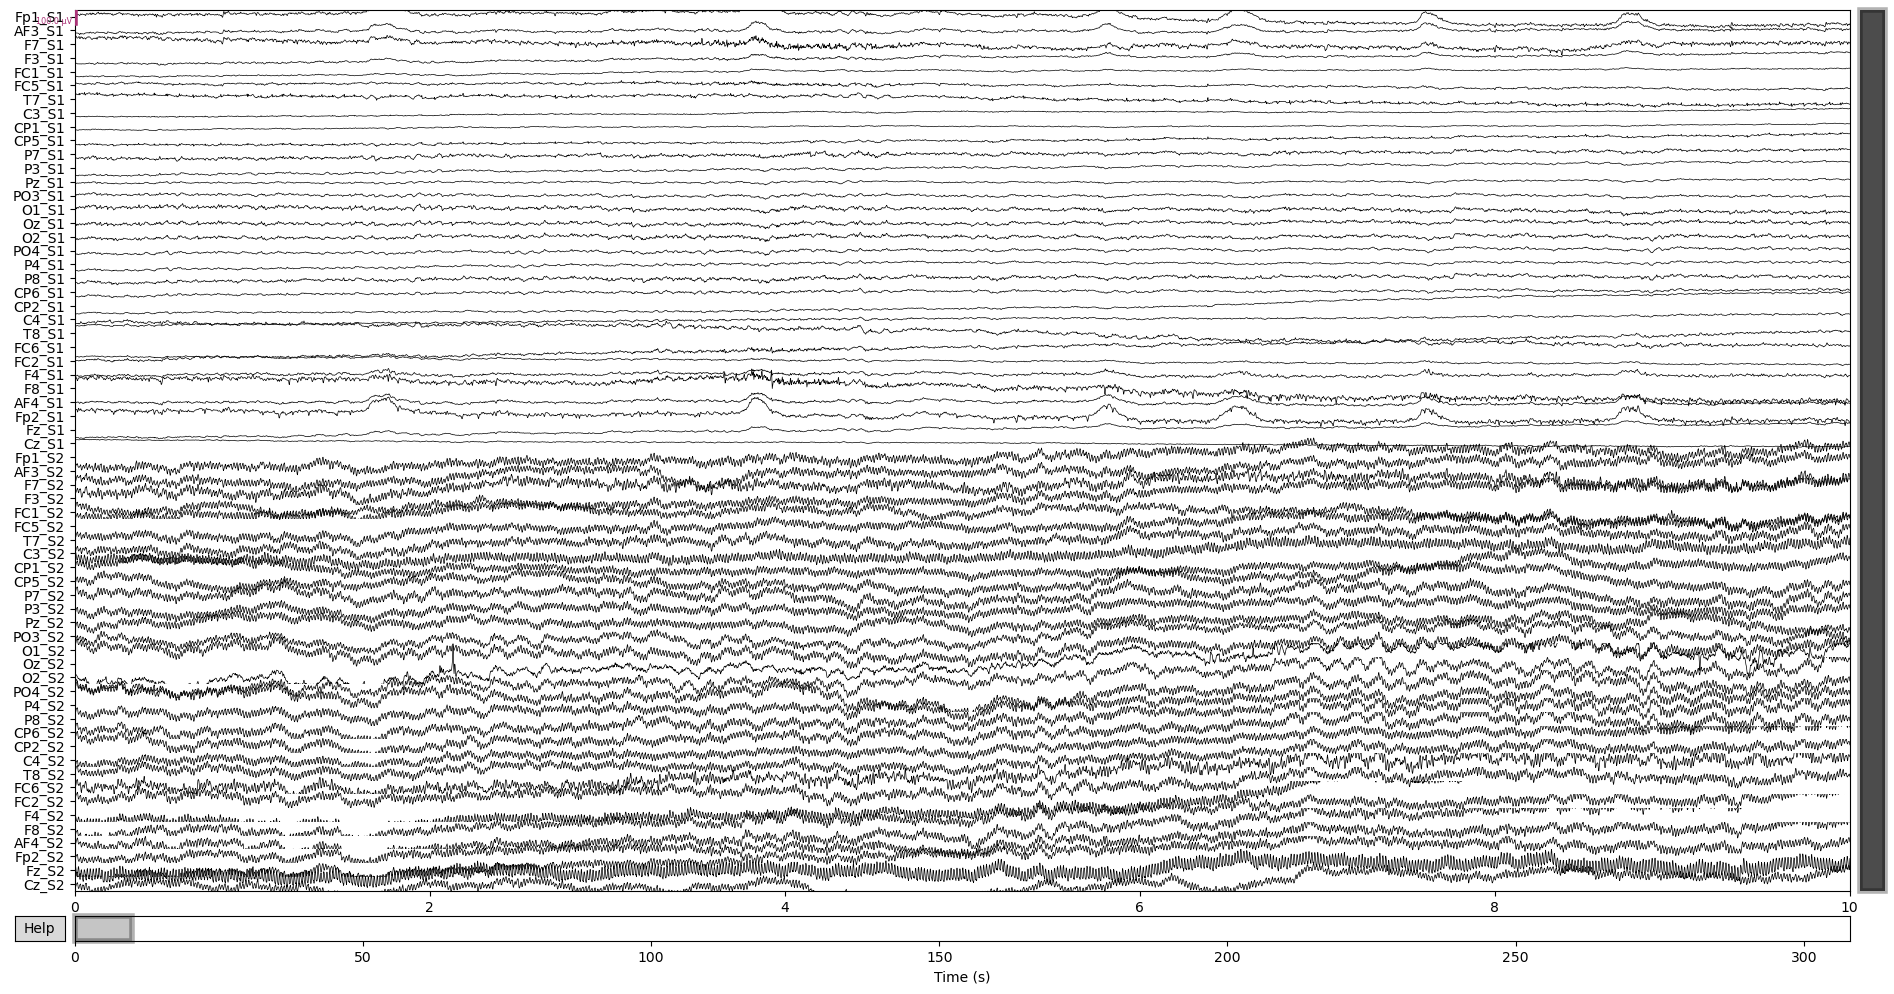

In [26]:
raw.plot(show=False, start=0, n_channels=len(change_ch_names_dic_S1), remove_dc=True, scalings=std_scale)
plt.show()

Effective window size : 4.000 (s)


C:\Users\mcwee\AppData\Local\Temp\ipykernel_14560\645303734.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(show=False)


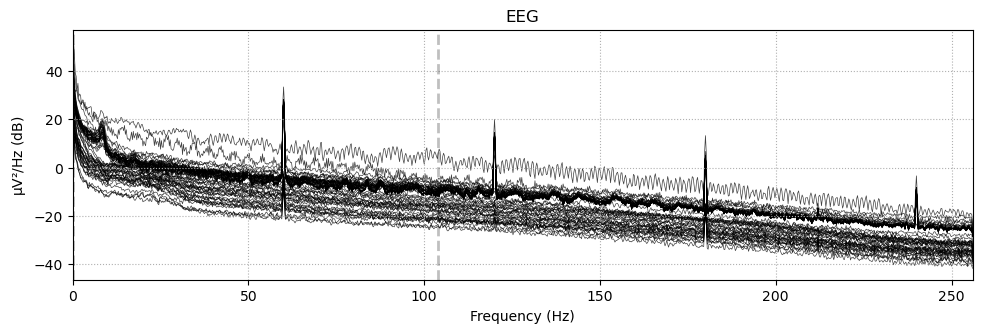

In [28]:
raw.plot_psd(show=False)
plt.show()

## Pre-processing dual-EEG

Let's separate the merged EEG data in two objects containning each and respectively the parent's and kid's channels.<br>

To do so we:
1. 'Duplicate' the merged file while dropping the channels corresponding to the other partcipant
2. Create a remplacement dictionary to rename the kid's channels so they match the parent's (this step is required for ICA to be applied later without error)

In [29]:
raw_kid    = raw.copy().drop_channels(s1_chans_new)
raw_parent = raw.copy().drop_channels(s2_chans_new)

In [30]:
# Create the remplacement dict
rename_kid_with_parent = dict(zip(s2_chans_new, s1_chans_new))

# Apply renaming 
raw_kid.rename_channels(rename_kid_with_parent)

<RawEDF | W2W_2606_movie.bdf, 32 x 157696 (308.0 s), ~38.5 MB, data loaded>

## HERE

#### Now we set the montage

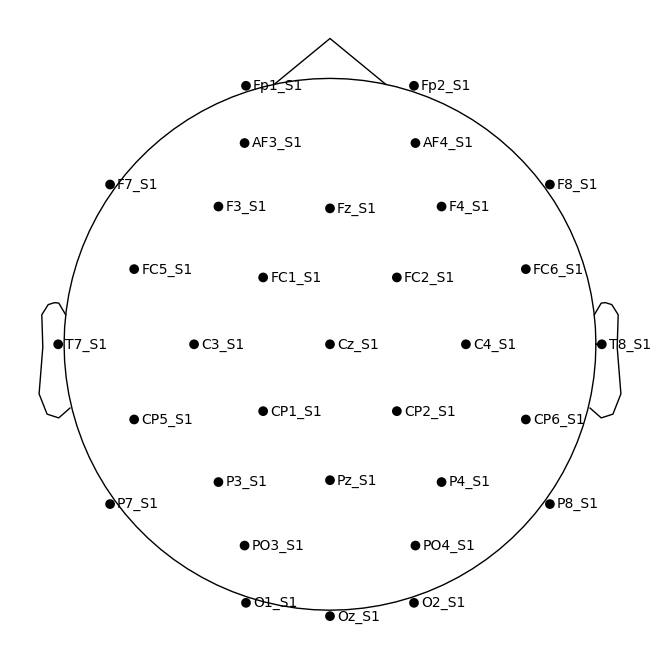

In [32]:
eeglab_montage_parent = chan_loc + "Parentonly_32_NoEXG.locs"
eeglab_montage_kid    = chan_loc + "Parentonly_32_NoEXG.locs"

montage_parent = mne.channels.read_custom_montage(eeglab_montage_parent)
montage_kid    = mne.channels.read_custom_montage(eeglab_montage_kid)

raw_kid.set_montage(montage_kid)
raw_parent.set_montage(montage_parent)

raw_kid.plot_sensors(show_names=True, show=False)
plt.show()
# epochs_S2.plot_sensors(show_names=True, show=False)
# plt.show()
# epochs_S1.plot_psd(spatial_colors=True, show=False)
# plt.show()

#### Remove suffix from each subject so S2's channels don't end in _S1 HERE

In [ ]:
#TO ADD 

#### Interpolation of bad channels (kid & parent)

In [ ]:
to_append=['Oz_S1', 'Fz_S1', 'PO3_S1']
raw_kid.info['bads'].extend(to_append)

In [ ]:
raw_kid.plot(show=False, scalings=dict(eeg=100e-6))
plt.show()

The method used by MNE to interpolate : [Link](https://www.sciencedirect.com/science/article/abs/pii/0013469489901806?via%3Dihub)

In [ ]:
raw_kid = raw_kid.interpolate_bads(reset_bads=True)

In [ ]:
raw_kid.plot(show=False, scalings=dict(eeg=100e-6))
plt.show()

## THERE


- *STEP 1*: [High pass filter](https://mne.tools/stable/generated/mne.io.Raw.html?highlight=raw%20filter#mne.io.Raw.filter) the data at .1Hz to remove drift and DC offset. *More on hpf and DC offset removal* [ref 1](https://sccn.ucsd.edu/githubwiki/files/eeglab2019_aspet_artifact_and_ica.pdf), [ref 2](https://neuroimage.usc.edu/forums/t/selecting-baseline-time-range-to-remove-dc-offset/17100)
- *STEP 2*: Remove poweline noise at frequency 60, 120, 180, 240Hz. [MNE source](https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#power-line-noise)
- *STEP 3*: Re reference each participant to their own Cz

In [ ]:
# STEP 1
# High pass filter the data at .1Hz to remove drift // Remove DC offset too
raw_kid.filter(l_freq = .1, h_freq = None)
raw_parent.filter(l_freq = .1, h_freq = None)

In [ ]:
# STEP 2
# Removing poweline noise
freqs_to_remove = (60, 120, 180, 240)
raw_kid    = raw_kid.copy().notch_filter(freqs=freqs_to_remove)
raw_parent = raw_parent.copy().notch_filter(freqs=freqs_to_remove)

# Optionnal Plotting
# for title, data in zip(['Un', 'Notch '], [raw_parent, raw_notched]):
#     fig = data.plot_psd(fmax=250, average=True)
#     fig.subplots_adjust(top=0.85)
#     fig.suptitle('{}filtered'.format(title), size='xx-large', weight='bold')
# plt.show()

**STEP 3** Re-reference each Raw.

In [ ]:
# Plot before
raw_plot = raw_parent.plot(show=False, start=0, n_channels=len(change_ch_names_dic_S1), remove_dc=True)
plt.show()

Reference to each participant to their scalp average ([mne.setting_eeg_reference](https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html#setting-or-changing-the-reference-channel))

In [ ]:
# STEP 2
# Set reference channel to Cz for each participant
raw_kid.set_eeg_reference(ref_channels='average')
raw_parent.set_eeg_reference(ref_channels='average')

# Set an average reference 
# raw_kid.set_eeg_reference(ref_channels='average')
# raw_parent.set_eeg_reference(ref_channels='average')

# raw_kid.info['bads'].append('Cz_S1')
# raw_parent.info['bads'].append('Cz_S1')

In [ ]:
# Plot after
raw_plot = raw_kid.plot(show=False, start=0, n_channels=len(change_ch_names_dic_S1), remove_dc=True, scalings=dict(eeg=100e-6))
plt.show()

## Create the `events` dataframe


#### Read behavioral events

For each session (e.g., book, puzzle, movie, _____)  x dyad, we have a TXT file containing, for each second (rows), the participants' behavioral code. 

NB: the onset times are in sec.

In [ ]:
#  Read TSV file and specify variable names 
event_tsv = pd.read_csv(ecode_file, sep="\t",
                       names=["item", "bepoch", "ecode", "label", "onset", "diff", "dura", "b_flags", "a_flags", "enable", "bin"],
                       dtype={"ecode" : "int64"})

# Print file's info
print("Events found in that file: %i" % event_tsv.shape[0])
event_tsv.head()

MNE represents events timing as sample index instead of seconds. Here we go from the time (sec) domain to the frequency domain (Hz)

In [ ]:
# Convert seconds to samples
event_tsv['onset'] *= raw.info['sfreq']

event_tsv.head()

See the event codes (called "ecode") we have and how many of each

In [ ]:
print("there are %i different event code(s) in this file: " % len(event_tsv['ecode'].unique()))
tmp = event_tsv.groupby('ecode')['ecode']
tmp.count()

> ❗️ We have a small problem here ❗️ 

MNE doesn't work with events whose code are > INT32_MAX (e.g., 2 147 483 647), some of ours exceed that value (e.g., 3221200000, 3222200000).
Because of that, we have to convert the `ecode` of our present data frame to shorten versions.

In [ ]:
# This needs to be flexible. I think the last 2 digits are always 0 at this stage, 
# so if ecode >10000 then ecode = ecode/100.

def divide_big_ecodes(x):
    if x > 10000:
        return int(x / 100)
    else:
        return x

event_tsv['ecode'] = event_tsv['ecode'].apply(divide_big_ecodes)


########################## below is the old method 
# remplace_dict = {
#     1002200000:10022,
#     5010220000:501022,
#     5010240000:501024,
#     6000203400:60002034,
#     6000203500:60002035,      
#     3222200000:32222,
#     6000241300:60002413,
#     6000243100:60002431,
#     2021200000:20212,
#     3221200000:32212,
#     7000000000:70000}

# event_tsv = event_tsv.replace({"ecode": remplace_dict})

In [ ]:
print("Here are the newly named 'ecode' : ", event_tsv['ecode'].unique())

#### Convert our custom event df to a MNE-friendly event df.

The MNE-friendly event df has 3 columns:
1. onset – The onset of the event in terms of sample index
2. dontuse – Mendatory but irrelevant for us. This column can also serve as a filter for bad events.
3. ecode – The ecode associated to the event 

So we have to add the needed 'dontuse' column to `event_tsv` dataframe before formating it for MNE. 

See [[link]](https://mne.tools/stable/glossary.html#term-events) to understand why that is the requiered structure for the MNE event df.

In [ ]:
event_tsv['dontuse'] = 0

# Select column of interest
events_selected = event_tsv.loc[:,['onset', 'dontuse','ecode']]

events_selected.head(10)

## Sample the `Raw` EEG data using our `event` df

### The [mne.epochs.make_metadata()](https://mne.tools/stable/generated/mne.epochs.make_metadata.html?highlight=make_metadata#mne.epochs.make_metadata) method

With mne.epochs.make_metadata(), we can define "events of interest" (here, a specific set of ecode we're interrested in) as well as a time window around them (e.g., what will become our 1sec epochs)
The function returns a callable object for mne.Epochs to create the `epochs` object using our custom `events` and `Raw`.

NB: The time window boundaries used in creating the metadata object don't have to be the same as those used later when epoching). 

In [ ]:
# Convet the events df to np so MNE is happy
events_selected = events_selected.to_numpy()

In [ ]:
event_id = dict()
for i in event_tsv['ecode'].unique():
    event_id[str(i)] = i 

event_id

We now create three objects with the mne.epochs.make_metadata method (metadata, events, event_id). We define the size of a metadata object as being 1sec long while starting at the event's 1st sample.

In [ ]:
meta_tmin, meta_tmax = 0.0, 1.0 # In seconds

# Define our ecode of interrest 
# ecodeOI = ['20212000', 'any other ecode']

metadata, events, event_id = mne.epochs.make_metadata(
    
    events=events_selected,
    event_id=event_id,
    tmin= meta_tmin, tmax= meta_tmax,

    # Here, we segment the whole eeg in 1sec epochs so 
    # ICA can be  performed on a maximal amount of data.

    # To select only event of choices, uncoment the line below
    # row_events=ecodeOI, 
    
    sfreq=raw.info['sfreq']
    )

events = events.astype(int)

metadata.head()

In [ ]:
event_plot = mne.viz.plot_events(
    events, raw.info['sfreq'], 
    event_id=event_id,
    show=False)
plt.show()

### Create the `Epoch` object for both subject

In [ ]:
epochs_tmin, epochs_tmax = 0.0, 1.0  # epochs range in sec
reject = {'eeg': 250e-6}  # exclude epochs with strong artifacts

epochs_S1 = mne.Epochs(
    
    raw=raw_parent, 
    events=events,
    event_id=event_id,

    tmin=epochs_tmin, tmax=epochs_tmax,
    
    metadata=metadata,
    
    event_repeated= 'merge',
    baseline=None,

    # reject=reject, 
    preload=True)

epochs_S2 = mne.Epochs(
    
    raw=raw_kid, 
    events=events,
    event_id=event_id,

    tmin=epochs_tmin, tmax=epochs_tmax,
    
    metadata=metadata,
    
    event_repeated= 'merge',
    baseline=None,

    # reject=reject, 
    preload=True)

# epochs_S2 = epochs_S1.copy()

In [ ]:
# Just checking that each participant has the same nb of epochs
mne.epochs.equalize_epoch_counts([epochs_S1, epochs_S2])

Save each participant's epoch object. 

In [ ]:
epochs_S1.save(saves + subject + "_" + context + "-S1" + "-epo.fif", overwrite= True, verbose=False)
epochs_S2.save(saves + subject + "_" + context + "-S2" + "-epo.fif", overwrite= True, verbose=False)

## Pre-processing (ICA / Ar)

>>>>>>> Find and reject bad channels

Use [mne.preprocessing.find_bad_channels_maxwell](https://mne.tools/stable/generated/mne.preprocessing.find_bad_channels_maxwell.html?highlight=find_bad_channels_maxwell#mne-preprocessing-find-bad-channels-maxwell) to find the bad channel and [mne.Epochs.interpolate_bads](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.interpolate_bads) to interpolate them.


**To enable interactive epoch.plots run `%matplotlib qt`**
Here are some reference
- In Hypyp, for both ICA and Autoreject see the end of [this tutorial](https://github.com/ppsp-team/HyPyP/blob/master/tutorial/getting_started.ipynb). 
    - This is the pipeline that is inserted below. 
    - There is also another workflow in that tutorial that enables computing PDC based on MVARICA approach
- Hypyp's ICA/Ar is based on MNE's [ICA class](https://mne.tools/stable/generated/mne.preprocessing.ICA.html?highlight=ica#mne.preprocessing.ICA) (various tutorial at the end).
- The [autoreject](https://autoreject.github.io/stable/index.html) package is a prerequise.

> **Pre requisite :** install autoreject<br>
> See this [link](https://api.github.com/repos/autoreject/autoreject/zipball/master), or un-comment and run the following cell.



In [ ]:
# ! pip install -U autoreject

# You might need that too
# ! pip install -U h5io

In [ ]:
# # # EEG data manipulation
# import mne

# # Hyperscanning analysis
# import hypyp

# # Useful data science tools
# import pandas as pd
# import numpy as np
# import re # regular expressions

# # Plotting
# import matplotlib.pyplot as plt

# # Platform handling
# from sys import platform

# ###########

# if platform == "darwin":  # OS X
#     root     = "../../W2W-Data/W2W-EEG/Franck_eeg_share/"
#     saves    = "../../W2W-Data/W2W-EEG/Franck_eeg_share/W2W-saves/"
#     chan_loc = "./channel_info/locs_files/"
# elif platform == "win32": # Windows
#     root = "C:\\Users\\mcwee\\Documents\\HyPyP\\social_eeg_project\\data\\"
#     saves = "C:\\Users\\mcwee\\Documents\\HyPyP\\social_eeg_project\\data\\saves\\"
# else:
#     print("Please insert manually your 'study root' path and 'saves' path")
# ############
# subject = 'W2W_2606'
# context = 'movie'

# # The line below can be substitued for  loop running through participants
# bdf_file = subject + "_" + context + ".bdf"
# txt_file = subject + "_" + context + "_main.txt"

# ecode_file = root + txt_file
# eeg_file   = root + bdf_file

We now re-load the data:

In [ ]:
epochs_S1 = mne.read_epochs(saves + subject + "_" + context + "-S1" + "-epo.fif", preload=True, verbose=False)
epochs_S2 = mne.read_epochs(saves + subject + "_" + context + "-S2" + "-epo.fif", preload=True, verbose=False)

The rejection dictionary gives the rejection threshold (the one with the lowest error acrros the folds)
[Full explanation](https://autoreject.github.io/stable/explanation.html)

Here, we set up variables needed to run autoreject

> How to interpolate a bad channel on MNE.Epoch [LINK](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.interpolate_bads)

In [ ]:
from autoreject import AutoReject, compute_thresholds

exclude_S1 = []  # XXX
exclude_S2 = []  # XXX
picks_S1 = mne.pick_types(epochs_S1.info, meg=False, eeg=True, stim=False,
                       eog=False, exclude=exclude_S1)
picks_S2 = mne.pick_types(epochs_S2.info, meg=False, eeg=True, stim=False,
                       eog=False, exclude=exclude_S2)                    

**Run auto-reject on S1 (Parent) to automatically interpolate before ICA**

In [ ]:
ar_S1 = AutoReject(
    picks=picks_S1, 
    random_state=42, 
    n_jobs=1, 
    n_interpolate = np.array([1, 4, 6, 32]), 
    verbose=True)

epochs_S1_ar, reject_S1_log = ar_S1.fit_transform(epochs_S1, return_log=True)

**Run auto-reject on S2 (Child) to automatically interpolate before ICA**


In [ ]:
ar_S2 = AutoReject(
    picks=picks_S2, 
    random_state=42, 
    n_jobs=1, 
    n_interpolate = np.array([1, 4, 6, 32]), 
    verbose=True)

epochs_S2_ar, reject_S2_log = ar_S2.fit_transform(epochs_S2, return_log=True)

In [ ]:
ar_S1.save(saves_ar + subject + "_" + context + "-S1" + "-ar-epo.hdf5", overwrite= True)
ar_S2.save(saves_ar + subject + "_" + context + "-S2" + "-ar-epo.hdf5", overwrite= True)

In [ ]:
epochs_S1_ar.save(saves_ar + subject + "_" + context + "-S1" + "-ar-epo.fif", overwrite= True, verbose=False)
epochs_S2_ar.save(saves_ar + subject + "_" + context + "-S2" + "-ar-epo.fif", overwrite= True, verbose=False)

In [ ]:
reject_S2_log.plot('horizontal', show=False)
plt.show()

In [ ]:
# %matplotlib qt

In [ ]:
reject_S2_log.plot_epochs(epochs_S2, scalings=dict(eeg=100e-6))

In [ ]:
reject_S2_log.plot_epochs(epochs_S2, scalings=dict(eeg=100e-6))

In [ ]:
# Plot only the dropped epochs
epochs_S2_ar.plot(scalings=dict(eeg=100e-6))

In [ ]:
# epochs_S2_ar.plot(scalings=dict(eeg=100e-6))

***NOW ICA***

>>>>>>> **BREAK PIPELINE HERE**
- Include tools to observe the components independently

In [ ]:
reject_S2_log.

In [ ]:
icas = hypyp.prep.ICA_fit([epochs_S1_ar, epochs_S2_ar],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state= 42)

In [ ]:
cleaned_epochs_ICA = hypyp.prep.ICA_choice_comp(icas, [epochs_S1_ar, epochs_S2_ar])

Now performing Auto-reject

In [ ]:
cleaned_epochs_AR, dic_AR = hypyp.prep.AR_local(cleaned_epochs_ICA, strategy="union", threshold=50.0, verbose=True)

Now picking the preprocessed epochs for each participant

In [ ]:
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

**INTERPOLATION?** using MNE's spherical spline methods ([mne tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html#interpolating-bad-channels), the method [mne.Epochs.interpolate_bads](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.interpolate_bads) for `mne.Epoch`)

>>>>>> **Idea: Vizualize/Compare dropped epoch in each subject after preprocessing**

## Select event of interest

How to [select epochs using metadata queries](https://mne.tools/stable/auto_tutorials/epochs/30_epochs_metadata.html#selecting-epochs-using-metadata-queries)

In [ ]:
print(epochs_S1['70000'])

## Inter-brain connectivity analysis

In [ ]:
data_inter = np.array([epochs_S1, epochs_S2])
results_intra = []

In [ ]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}

In [ ]:
complex_signal = hypyp.analyses.compute_freq_bands(data_inter, epochs_S1.info['sfreq'],
                                             freq_bands)

In [ ]:
complex_signal.shape

In [ ]:
results = hypyp.analyses.compute_sync(complex_signal, 'ccorr', epochs_average=True)

In [ ]:
results.shape

### Questions left to answer:

* What bound are the most sensible to use for epoching (e.g., 0 to 1sec or -0.2 to 0.8)?
  * Answer is 0 to 1sec
* do we need to operate baseline correction when epoching with the metadata method?
* The 'Status' channel